# 1.Data Preparation and Transformation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

Read in and convert the raw data to Pandas DataFrame. Drop the repetitive index column. 

In [2]:
data = pd.read_csv('data.txt', sep = '|', encoding = 'unicode_escape')
data = data.iloc[:, 1:]
data.head()

,variable,value
0,score,65
1,score,98
2,score,85
3,score,83
4,score,115


Check for missing values and data errors

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2171 entries, 0 to 2170
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   variable  2171 non-null   object
 1   value     2171 non-null   object
dtypes: object(2)
memory usage: 34.0+ KB


In [4]:
data['variable'].value_counts() 

score      434
h          434
i          434
w          434
a          434
áº      1
Name: variable, dtype: int64

No missing values detected, but there is a noisy record that should be removed.

In [5]:
err = data['variable'].value_counts().index[-1]
data = data[data['variable'] != err] 
data['variable'].value_counts()

score    434
h        434
i        434
w        434
a        434
Name: variable, dtype: int64

Convert the dataframe from long to wide so that it's easier for further analysis and modeling.

In [6]:
df = data.loc[data['variable'] == 'score', ['value']
             ].rename(columns = {'value':'score'}).reset_index(drop = True)

for fea in ['w', 'h', 'a', 'i']:
    df = pd.concat([data.loc[data['variable'] == fea, ['value']
                            ].rename(columns = {'value':fea}).reset_index(drop = True)
                    , df], axis = 1)
df

,i,a,h,w,score
0,'121.117528602603',27,1,4,65
1,'89.3618817100663',25,1,4,98
2,'115.443164881725',27,1,4,85
3,'99.4496394360723',25,1,3,83
4,'92.7457099982118',27,1,4,115
...,...,...,...,...,...
429,'84.8774118257353',21,0,4,94
430,'92.9903917236843',23,1,4,76
431,'94.8597081943671',24,0,2,50
432,'96.8566241253673',21,1,2,88


In [7]:
np.all(df['i'].str.startswith("'")) and (np.all(df['i'].str.endswith("'")))

True

#### **Finalized Dataframe:**

##### **Continuous Variables - data type: float**
* **mother_IQ:** Renamed from variable **i**, which represents mother's IQ.<br>
* **mother_age_at_childbirth:** Renamed from variable **a**, which represents mother's age at child's birth.<br>
* **child_IQ:** Renamed from variable **score**, which represents child's IQ.<br>

##### **Categorical Variables - data type: string**
* **mother_work_experience:** Renamed from variable **w**, showing mother's work experience during the first 3 years of child's life. <br>
  *  **never_worked:** Renamed from level **1** , which means that mother has never worked in the first 3 years. <br>
  *  **worked_2or3:** Renamed from level **2** , which means that mother worked in the second or third year. <br>
  *  **parttime_1:** Renamed from level **3** , which means that mother worked part-time in the first year. <br>
  *  **fulltime_1:** Renamed from level **4** , which means that mother worked full-time in the first year.
  
##### **Binary Variables - data type: binary**
* **mother_finished_high_school:** Renamed from variable **h**, indicating whether mother completed high school. 1 means Yes and 0 means No.<br>
*  **mother_worked_2or3:** One hot encoding for mother_work_experience = 'worked_2or3'. 1 means True, 0 means False.<br>
*  **mother_parttime_1:** One hot encoding for mother_work_experience = 'parttime_1'. 1 means True, 0 means False. <br>
*  **mother_fulltime_1:** One hot encoding for mother_work_experience = 'fulltime_1'. 1 means True, 0 means False.

**Note:** Both one hot encodings and the original categorical form of **mother_work_experience** are included in the dataframe. One hot encodings are necessary for regression analysis while the original categorical form is easy for exploratory data analysis.

In [8]:
df = df.rename(columns = {'i':'mother_IQ', 
                          'a':'mother_age_at_childbirth',
                          'h':'mother_finished_high_school',
                          'w':'mother_work_experience',
                          'score':'child_IQ'})

df['mother_IQ'] = df['mother_IQ'].apply(lambda x: float(x[1:-1])) # always starts and ends with '
df['mother_age_at_childbirth'] = df['mother_age_at_childbirth'].apply(float)
df['mother_finished_high_school'] = df['mother_finished_high_school'].apply(int)
df['child_IQ'] = df['child_IQ'].apply(float)

df['mother_work_experience'] = df['mother_work_experience'].apply(
    lambda x: 'never_worked' if x == '1' 
    else ('worked_2or3' if x == '2' 
          else ('parttime_1' if x == '3' 
                else ('fulltime_1'))))

one_hot_var = pd.get_dummies(df['mother_work_experience'], prefix = 'mother').drop(columns = ['mother_never_worked'])
df = pd.concat([df, one_hot_var], axis = 1)

df

,mother_IQ,mother_age_at_childbirth,mother_finished_high_school,mother_work_experience,child_IQ,mother_fulltime_1,mother_parttime_1,mother_worked_2or3
0,121.117529,27.0,1,fulltime_1,65.0,1,0,0
1,89.361882,25.0,1,fulltime_1,98.0,1,0,0
2,115.443165,27.0,1,fulltime_1,85.0,1,0,0
3,99.449639,25.0,1,parttime_1,83.0,0,1,0
4,92.745710,27.0,1,fulltime_1,115.0,1,0,0
...,...,...,...,...,...,...,...,...
429,84.877412,21.0,0,fulltime_1,94.0,1,0,0
430,92.990392,23.0,1,fulltime_1,76.0,1,0,0
431,94.859708,24.0,0,worked_2or3,50.0,0,0,1
432,96.856624,21.0,1,worked_2or3,88.0,0,0,1


# 2.Exploratory Data Analysis

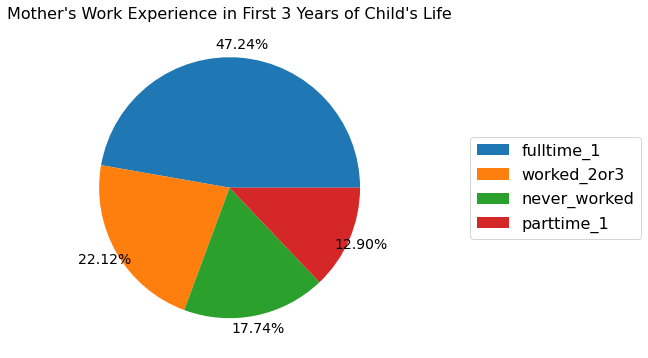

In [9]:
fig, ax = plt.subplots(figsize = (10,6))
portions = df['mother_work_experience'].value_counts(normalize = True)
ax.pie(portions, textprops={'fontsize': 14}, autopct = '%1.2f%%', pctdistance = 1.1)
plt.title("Mother's Work Experience in First 3 Years of Child's Life", fontsize = 16)
plt.legend(portions.index, bbox_to_anchor=(1.5,0.5), loc='center', fontsize=16)
plt.show()

* Nearly 80% of mothers have work experience during the first 3 years of their children's life, while most of them worked full-time in the first year and then quit. 

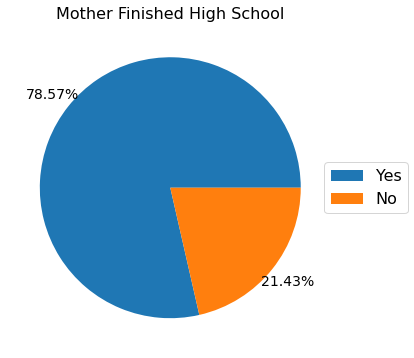

In [10]:
fig, ax = plt.subplots(figsize = (10,6))
portions = df['mother_finished_high_school'].apply(lambda x: 'Yes' if x==1 else 'No').value_counts(normalize = True)
ax.pie(portions, textprops={'fontsize': 14}, autopct = '%1.2f%%', pctdistance = 1.15)
plt.title('Mother Finished High School', fontsize = 16)
plt.legend(portions.index, bbox_to_anchor=(1.1,0.5), loc='center', fontsize=16)
plt.show()

* Most mothers have finished high school.

        mother_IQ    child_IQ  mother_age_at_childbirth
count  434.000000  434.000000                434.000000
mean   100.000000   86.797235                 22.785714
std     15.000000   20.410688                  2.701070
min     71.037405   20.000000                 17.000000
25%     88.660321   74.000000                 21.000000
50%     97.915254   90.000000                 23.000000
75%    110.272742  102.000000                 25.000000
max    138.893106  144.000000                 29.000000


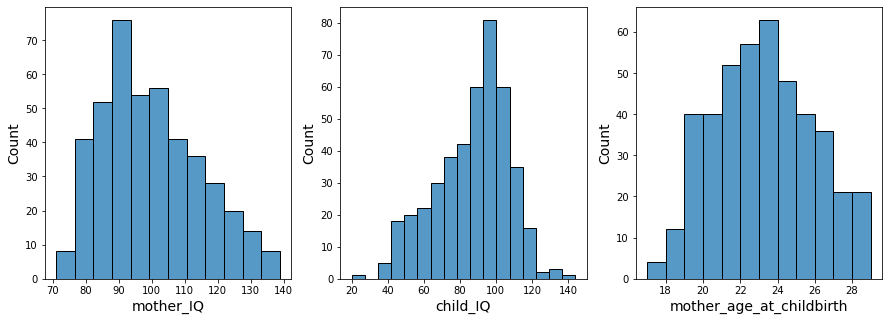

In [11]:
print(df[['mother_IQ', 'child_IQ', 'mother_age_at_childbirth']].describe())

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for fea, subplot in zip(['mother_IQ', 'child_IQ', 'mother_age_at_childbirth'], ax.flatten()):
    sns.histplot(df[fea], ax = subplot)
    subplot.set_xlabel(fea, fontsize = 14)
    subplot.set_ylabel('Count', fontsize = 14)
plt.show()

* Mother's age at childbirth is roughly normally distributed from 17 to 29. Most mothers gave birth to their children at an age around 23.
* The distribution of mother_IQ is slightly right skewed. The majority of mothers' IQs are between 80 and 110, with fewer and fewer having higher values than this range.
* The distribution of child_IQ is left skewed, with most children having IQs between 80 and 110 and a long tail of children having lower IQs.
* Compared to mother_IQ, child_IQ is more widely distributed, with a smaller lower bound and a higher upper bound. 

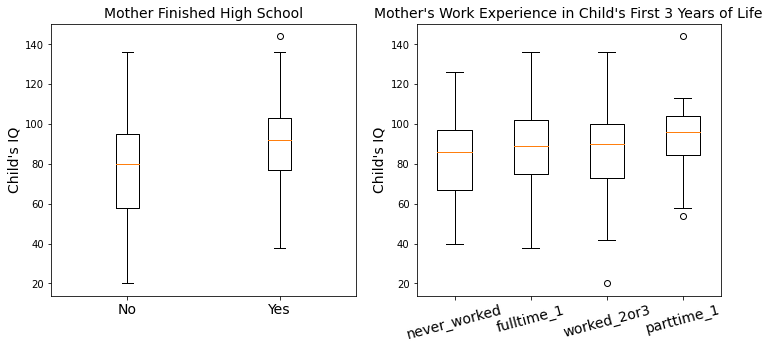

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

group_idx = df.groupby('mother_finished_high_school')['child_IQ'].median().sort_values().index
group_idx_str = [ ('Yes' if idx==1 else 'No') for idx in group_idx]
ax[0].boxplot([df.loc[df['mother_finished_high_school'] == idx, 'child_IQ'] for idx in group_idx] , labels = group_idx)
ax[0].set_ylabel("Child's IQ", fontsize = 14)
ax[0].set_xlabel(None)
ax[0].set_title('Mother Finished High School', fontsize = 14)
ax[0].set_xticklabels(group_idx_str, fontsize = 14)

group_idx = df.groupby('mother_work_experience')['child_IQ'].median().sort_values().index
ax[1].boxplot([df.loc[df['mother_work_experience'] == idx, 'child_IQ'] for idx in group_idx] , labels = group_idx)
ax[1].set_ylabel("Child's IQ", fontsize = 14)
ax[1].set_xlabel(None)
ax[1].set_title("Mother's Work Experience in Child's First 3 Years of Life", fontsize = 14)
ax[1].set_xticklabels(group_idx, rotation = 15, fontsize = 14)
plt.show()

* According to the dataset, mothers who have high school degrees or work experience in the first 3 years of their children's life tend to have children with higher IQs. 

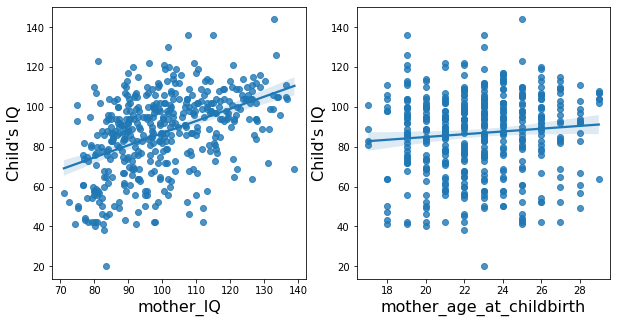

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for fea, subplot in zip(['mother_IQ','mother_age_at_childbirth'], ax.flatten()):
    sns.regplot(x = fea, y = 'child_IQ', data = df, ax = subplot)
    subplot.set_xlabel(fea, fontsize = 16)
    subplot.set_ylabel("Child's IQ", fontsize = 16)
    
plt.show()

* Child's IQ is clearly positively correlated with mother's IQ but only slightly correlated with mother's age at childbirth. 

# 3.Regression Analysis

**This part includes three cases:**
  1. Single predictor
  2. Multiple predictors
  3. Multiple predictors with an interaction term

## 3.1 - Single Predictor

According to previous data analysis, mother's IQ seems to have significant impact on child's IQ. Therefore, I chose **mother_IQ** as the predictor for child's IQ. 

In [14]:
variables = ['mother_IQ']

X = sm.add_constant(df[variables])
Y = df['child_IQ']
fit = sm.OLS(Y,X).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:               child_IQ   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     108.6
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           7.66e-23
Time:                        22:55:11   Log-Likelihood:                -1875.6
No. Observations:                 434   AIC:                             3755.
Df Residuals:                     432   BIC:                             3763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7998      5.917      4.360      0.0

#### **Model Summary:**

* The model **child_IQ = 0.61⋅mother_IQ + 25.7998** describes the expectation of child_IQ as a linear function of mother_IQ. 
* R-squared = 0.201 means that 20.1% of the variance observed in child_IQ could be explained by the linear model.
* The p value for F-statistic is very close to zero, which indicates that the linear relationship is statisitcally significant.

#### **Interpretation of Coefficients:**

* **const**: The expected value of child's IQ is **25.7998** given that mother's IQ equals zero. This coefficient is significantly different from zero, since the corresponding p value is very small.  
* **mother_IQ**: If mother's IQ increases by one, child's IQ will increase by **0.61** on average. This relationship is statistically significant, since the corresponding p value is very small.  
<br> *Note: assume a significance level of 0.05*

#### **Model Assumptions:**

* **Linearity:** The expectation of regressand (child_IQ) is a linear function of the predictor (mother_IQ).
* **Homoscedasticity:** The variances of regression errors are constant and equal.
* **Normality:** Given the value of the predictor (mother_IQ), the regressand (child_IQ) is normally distributed.
* **Independence:** The variances of regression errors are independent.

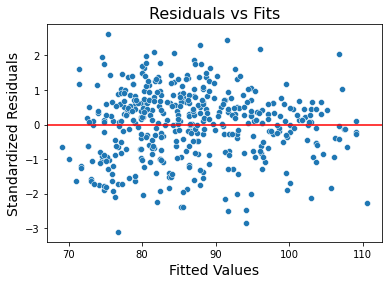

In [15]:
sns.scatterplot(x=fit.fittedvalues, y=fit.resid_pearson)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Fits', fontsize = 16)
plt.xlabel('Fitted Values', fontsize = 14)
plt.ylabel('Standardized Residuals', fontsize = 14)
plt.show()

* The average of residuals remains close to 0, which indicates that points are centered around a straight line and therefore the assumption of **linearity** holds.
* The spread of residuals remains roughly constant, which means that the assumption of **homoscedasticity** holds.
* There is no clear correlation between residuals and fitted values. Since the model has only one predictor, we can also conclude that there is no clear correlation between residuals and the predictor. Therefore, the assumption of **independence** holds.

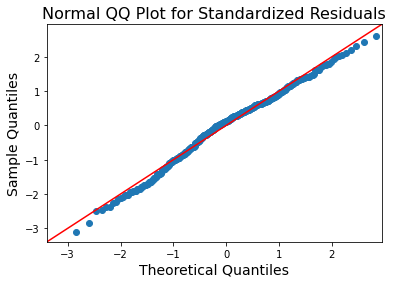

In [16]:
sm.graphics.qqplot(fit.resid_pearson, line = '45')
plt.title('Normal QQ Plot for Standardized Residuals', fontsize = 16)
plt.xlabel('Theoretical Quantiles', fontsize = 14)
plt.ylabel('Sample Quantiles', fontsize = 14)
plt.show()

* The plot of the theoretical quantiles of normal distribution vs the observed sample quantiles is approximately linear, which indicates that the assumption of **normality** holds.

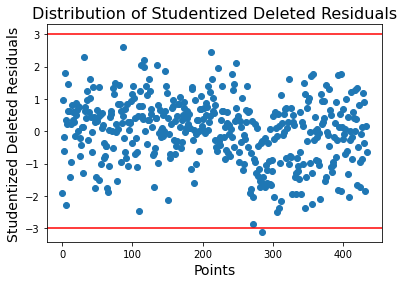

In [17]:
# use studentized deleted residuals to check for outliers
stud_res = pd.Series(fit.get_influence().get_resid_studentized_external())

plt.scatter(stud_res.index, stud_res.values)
plt.axhline(y=3, color='red', linestyle='-')
plt.axhline(y=-3, color='red', linestyle='-')
plt.title('Distribution of Studentized Deleted Residuals', fontsize = 16)
plt.xlabel('Points', fontsize = 14)
plt.ylabel('Studentized Deleted Residuals', fontsize = 14) 
plt.show()


* In general, a studentized deleted residual with an absolute value greater than 3 is regarded as an outlier. From the plot we can see that, there is only one outlier detected.

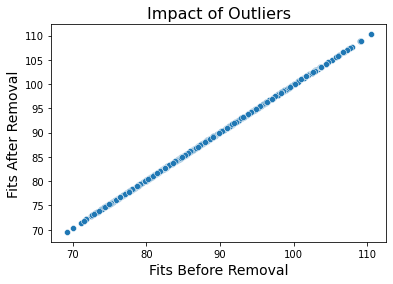

In [18]:
remove = (np.abs(stud_res) > 3)
Xr = X[~remove]
Yr = Y[~remove]
fitr = sm.OLS(Yr,Xr).fit()

sns.scatterplot(x=fit.fittedvalues[~remove], y=fitr.fittedvalues)
plt.title('Impact of Outliers', fontsize = 16)
plt.xlabel('Fits Before Removal', fontsize = 14)
plt.ylabel('Fits After Removal', fontsize = 14)
plt.show()

* Fitted values after the removal of outliers are approximately unchanged, which means that the impact of outliers is negligible. 

## 3.2 - Multiple Predictors

Here I tried to include all the predictors: **mother_IQ, mother_age_at_childbirth, mother_finished_high_school, mother_fulltime_1, mother_parttime_1, mother_worked_2or3**

In [19]:
variables = ["mother_IQ", "mother_age_at_childbirth", "mother_finished_high_school", 
             "mother_fulltime_1", "mother_parttime_1", "mother_worked_2or3"]

selected_vars = variables

X = sm.add_constant(df[selected_vars])
Y = df["child_IQ"]
fit = sm.OLS(Y,X).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:               child_IQ   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     20.22
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           7.55e-21
Time:                        22:55:14   Log-Likelihood:                -1870.0
No. Observations:                 434   AIC:                             3754.
Df Residuals:                     427   BIC:                             3783.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

* The OLS results indicate that there might be strong multicollinearity. We can further look into that by checking the Variance Inflation Factor (VIF) for each predictor.

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
vif_data = pd.DataFrame()
vif_data['predictor'] = selected_vars
  
# calculating VIF for each predictor
vif_data['VIF'] = [variance_inflation_factor(df[selected_vars], i) for i in range(len(selected_vars))]
  
print(vif_data)

                     predictor        VIF
0                    mother_IQ  33.335616
1     mother_age_at_childbirth  32.762589
2  mother_finished_high_school   5.440816
3            mother_fulltime_1   3.902524
4            mother_parttime_1   1.800605
5           mother_worked_2or3   2.206476


* In general, if a predictor has a VIF greater than 10, it means that the predictor is highly correlated with the rest of predictors. Here we can see that multicollinearity is quite severe, which will reduce the statistical power of the regression model.
* We could reduce multicollinearity using forward regression with BIC as selection metric.

In [21]:
def forward_regression(X, Y, threshold = 0):
    included = []
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_metric = pd.Series(dtype=np.float64, index=excluded)
        base_model = sm.OLS(Y, sm.add_constant(X[included])).fit()
        for new_column in excluded:
            model = sm.OLS(Y, sm.add_constant(X[included+[new_column]])).fit()
            new_metric[new_column] = model.bic - base_model.bic
        best_metric = new_metric.min()
        if best_metric < threshold:
            best_feature = new_metric.index[new_metric.argmin()]
            included.append(best_feature)
            changed=True
            print(f'Added {best_feature} to model, due to the best BIC.')

        if not changed:
            break
    return included

In [22]:
selected_vars = forward_regression(df[variables], df['child_IQ'])

X = sm.add_constant(df[selected_vars])
Y = df["child_IQ"]
fit = sm.OLS(Y,X).fit()
print(fit.summary())

Added mother_IQ to model, due to the best BIC.
Added mother_finished_high_school to model, due to the best BIC.
                            OLS Regression Results                            
Dep. Variable:               child_IQ   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     58.72
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           2.79e-23
Time:                        22:55:16   Log-Likelihood:                -1872.0
No. Observations:                 434   AIC:                             3750.
Df Residuals:                     431   BIC:                             3762.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--

#### **Model Summary:**

* The model **child_IQ = 0.5639⋅mother_IQ + 5.9501⋅mother_finished_high_school + 25.7315** describes the expectation of child_IQ as a linear function of mother_IQ and mother_finished_high_school. 
* R-squared = 0.214 means that 21.4% of the variance observed in child_IQ could be explained by the linear model.
* The p value for F-statistic is very close to zero, which indicates that the linear relationship is statisitcally significant.

#### **Interpretation of Coefficients:**

* **const**: The expected value of child_IQ is **25.7315** given that both mother_IQ and mother_finished_high_school equal zero. This coefficient is significantly different from zero, since the corresponding p value is very small.  
* **mother_IQ**: If mother's IQ increases by one while mother_finished_high_school remains unchanged, child's IQ will increase by **0.5639** on average. This relationship is statistically significant, since the corresponding p value is very small.  
* **mother_finished_high_school**: Child's IQ will be **5.9501** higher on average if mother has completed high school while mother's IQ remains unchanged. This relationship is statistically significant, since the corresponding p value is very small.  
<br> *Note: assume a significance level of 0.05*

#### **Model Assumptions:**

* **Linearity:** The expectation of regressand (child_IQ) is a linear function of the predictors (mother_IQ, mother_finished_high_school).
* **Homoscedasticity:** The variances of regression errors are constant and equal.
* **Normality:** Given the values of the predictors (mother_IQ, mother_finished_high_school), the regressand (child_IQ) is normally distributed.
* **Independence:** The variances of regression errors are independent.

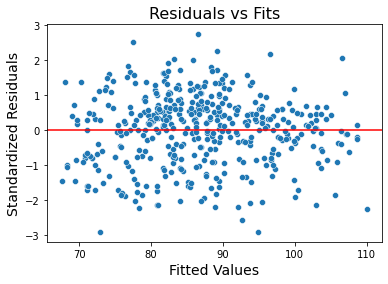

In [23]:
sns.scatterplot(x=fit.fittedvalues, y=fit.resid_pearson)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Fits', fontsize = 16)
plt.xlabel('Fitted Values', fontsize = 14)
plt.ylabel('Standardized Residuals', fontsize = 14)
plt.show()

* The average of residuals remains close to 0, which indicates that points are centered around a straight line and therefore the assumption of **linearity** holds.
* The spread of residuals remains roughly constant, which means that the assumption of **homoscedasticity** holds.
* There is no clear correlation between residuals and fitted values. However, to check whether the assumption of **independence** holds, we also need to look at residuals vs predictors plots.

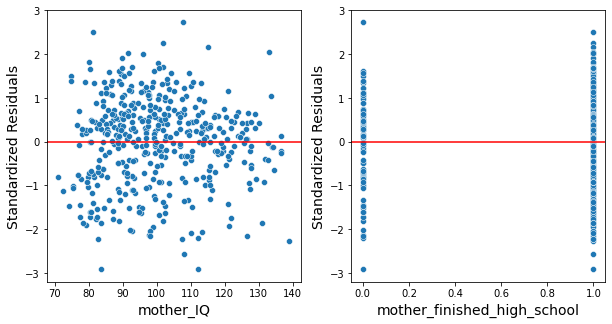

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for fea, subplot in zip(selected_vars, ax.flatten()):
    sns.scatterplot(x=X[fea], y=fit.resid_pearson, ax = subplot)
    subplot.axhline(y=0, color='r', linestyle='-')
    subplot.set_xlabel(fea, fontsize = 14)
    subplot.set_ylabel('Standardized Residuals', fontsize = 14)
    
plt.show()

*  There is no significant correlation between residuals and any predictor, so the assumption of **independence** holds.

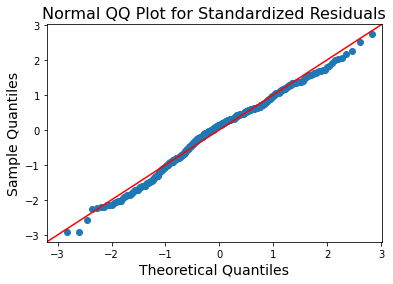

In [25]:
sm.graphics.qqplot(fit.resid_pearson, line = '45')
plt.title('Normal QQ Plot for Standardized Residuals', fontsize = 16)
plt.xlabel('Theoretical Quantiles', fontsize = 14)
plt.ylabel('Sample Quantiles', fontsize = 14)
plt.show()

* The plot of the theoretical quantiles of normal distribution vs the observed sample quantiles is approximately linear, which indicates that the assumption of **normality** holds.

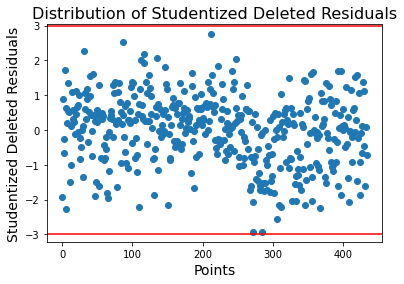

In [26]:
# use studentized deleted residuals to check for outliers
stud_res = pd.Series(fit.get_influence().get_resid_studentized_external())

plt.scatter(stud_res.index, stud_res.values)
plt.axhline(y=3, color='red', linestyle='-')
plt.axhline(y=-3, color='red', linestyle='-')
plt.title('Distribution of Studentized Deleted Residuals', fontsize = 16)
plt.xlabel('Points', fontsize = 14)
plt.ylabel('Studentized Deleted Residuals', fontsize = 14) 
plt.show()

* No outlier is detected.

## 3.3 - Multiple Predictors with an Interaction Term

Based on the model obtained in 3.2, an interaction term is added to study whether mother's IQ has a different effect on child's IQ if the value of mother_finished_high_school varies.

In [27]:
df['interaction_degree_IQ'] = df["mother_IQ"]*df["mother_finished_high_school"]

selected_vars = ["mother_IQ", "mother_finished_high_school", "interaction_degree_IQ"]
X = sm.add_constant(df[selected_vars])
Y = df["child_IQ"]
fit = sm.OLS(Y,X).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:               child_IQ   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     42.84
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           3.07e-24
Time:                        22:55:23   Log-Likelihood:                -1867.5
No. Observations:                 434   AIC:                             3743.
Df Residuals:                     430   BIC:                             3759.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

#### **Model Summary:**

* The model **child_IQ = 0.9689⋅mother_IQ + 51.2682⋅mother_finished_high_school - 0.4843⋅mother_IQ⋅mother_finished_high_school - 11.4820** describes the expectation of child_IQ as a linear function of mother_IQ, mother_finished_high_school, and their interaction. 
* For mothers who did not complete high school, the relationship between mother's IQ and child's IQ is: <br>   **child_IQ = 0.9689⋅mother_IQ - 11.4820**
* For mothers who completed high school, the relationship between mother's IQ and child's IQ is: <br>
  **child_IQ = 0.4846⋅mother_IQ + 39.7862**
* R-squared = 0.23 means that 23% of the variance observed in child_IQ could be explained by the linear model.
* The p value for F-statistic is very close to zero, which indicates that the model is statisitcally significant.
* Multicollinearity is not a problem if it's caused by introducing interactions terms.

#### **Interpretation of Coefficients:**

* **interaction**: The p value is very small, which means that mother_IQ has a significantly different effect on child_IQ as the value of mother_finished_high_school changes. If mother completed high school, the slope of mother's IQ will be **0.4843** lower.
* **const**: For mothers who did not complete high school, the expected value of child_IQ is **-11.4820** given that mother_IQ equals zero, but this result is not statistically significant due to the high p value. 
* **mother_IQ**: For mothers who did not complete high school, if mother's IQ increases by one, child's IQ will increase by **0.9689** on average. For mothers who completed high school, if mother's IQ increases by one, child's IQ will increase by **0.4846** on average. The relationship are statistically significant.
* **mother_finished_high_school**: Child's IQ will be **51.2682** higher on average if mother completed high school and mother's IQ equals 0. This result is statistically significant, since the corresponding p value is very small.
<br><br> *Note: assume a significance level of 0.05*

#### **Model Assumptions:**

* **Linearity:** The expectation of regressand (child_IQ) is a linear function of the predictors (mother_IQ, mother_finished_high_school, interaction term).
* **Homoscedasticity:** The variances of regression errors are constant and equal.
* **Normality:** Given the values of the predictors (mother_IQ, mother_finished_high_school, interaction term), the regressand (child_IQ) is normally distributed.
* **Independence:** The variances of regression errors are independent.

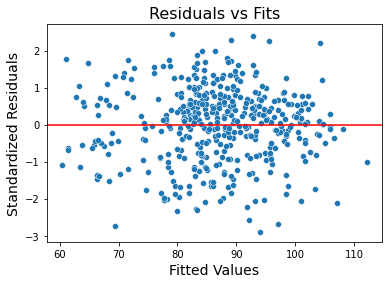

In [28]:
sns.scatterplot(x=fit.fittedvalues, y=fit.resid_pearson)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Fits', fontsize = 16)
plt.xlabel('Fitted Values', fontsize = 14)
plt.ylabel('Standardized Residuals', fontsize = 14)
plt.show()

* The average of residuals remains close to 0, which indicates that points are centered around a straight line and therefore the assumption of **linearity** holds.
* The spread of residuals remains roughly constant, which means that the assumption of **homoscedasticity** holds.
* There is no clear correlation between residuals and fitted values. However, to check whether the assumption of **independence** holds, we also need to look at residuals vs predictors plots.

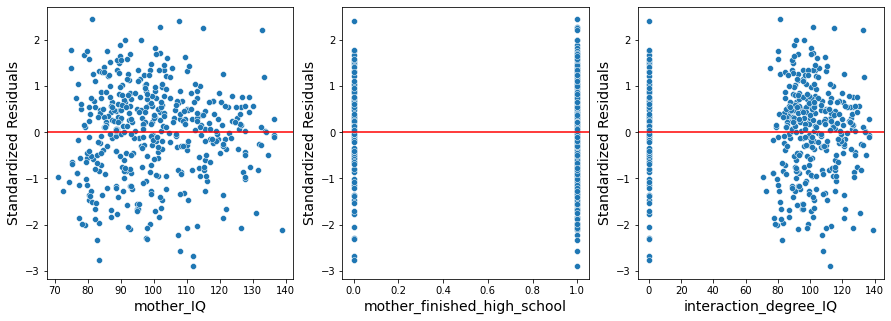

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))


for fea, subplot in zip(selected_vars, ax.flatten()):
    sns.scatterplot(x=X[fea], y=fit.resid_pearson, ax = subplot)
    subplot.axhline(y=0, color='r', linestyle='-')
    subplot.set_xlabel(fea, fontsize = 14)
    subplot.set_ylabel('Standardized Residuals', fontsize = 14)
    
plt.show()

*  There is no significant correlation between residuals and any predictor, so the assumption of **independence** holds.

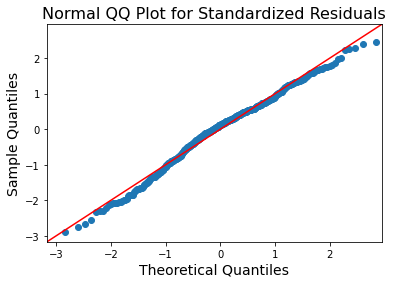

In [30]:
sm.graphics.qqplot(fit.resid_pearson, line = '45')
plt.title('Normal QQ Plot for Standardized Residuals', fontsize = 16)
plt.xlabel('Theoretical Quantiles', fontsize = 14)
plt.ylabel('Sample Quantiles', fontsize = 14)
plt.show()

* The plot of the theoretical quantiles of normal distribution vs the observed sample quantiles is approximately linear, which indicates that the assumption of **normality** holds.

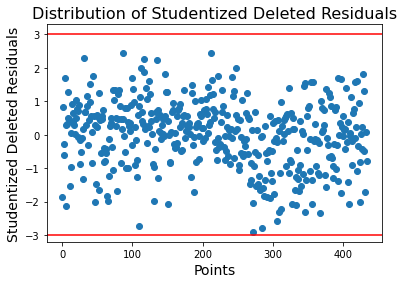

In [31]:
# use studentized deleted residuals to check for outliers
stud_res = pd.Series(fit.get_influence().get_resid_studentized_external())

plt.scatter(stud_res.index, stud_res.values)
plt.axhline(y=3, color='red', linestyle='-')
plt.axhline(y=-3, color='red', linestyle='-')
plt.title('Distribution of Studentized Deleted Residuals', fontsize = 16)
plt.xlabel('Points', fontsize = 14)
plt.ylabel('Studentized Deleted Residuals', fontsize = 14) 
plt.show()

* No outlier is detected.